# Signal Creation Pipeline

In [1]:
%load_ext autoreload
%autoreload 2

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from modules.signals import plot_realization
from modules.data_utils import load_reddit_data, load_bitcoin_data
from modules.data_cleaning import preprocess_data
from modules.sentiment_analysis import get_roberta_checkpoint
from modules.btc_price_data_processing import add_performance_metrics
from modules.utils import set_pandas_display_options
set_pandas_display_options()


## Load and clean data

In [3]:
df = load_reddit_data()

## Sentiment Analysis

In [4]:
# get checkpoint
sentiment_roberta = get_roberta_checkpoint()

# merge sentiment
df = pd.merge(df, sentiment_roberta, how="left", on="submission")

## Relevance filtering

In [5]:
# LDA filter
topic_keywords = pd.read_csv("topic_keywords.csv")
trading_keywords = topic_keywords.loc[topic_keywords["Topic"]=="Topic 2", "Keyword"].values

com_filter = (df["num_comments"] > 100)
lda_filter = df["selftext"].str.lower().str.contains("|".join(trading_keywords))
print(df.shape)
df_lda = df.loc[lda_filter].copy() # filter on LDA topics
print(df_lda.shape)

## Sentiment Signal

In [39]:
def get_alpha(df: pd.DataFrame, lag: int = 24):
    df["rolling_positive_score"] = df["positive_score"].rolling(lag).sum()
    df["rolling_negative_score"] = df["negative_score"].rolling(lag).sum()
    df["alpha"] = (df["rolling_positive_score"] - df["rolling_negative_score"]) / (df["rolling_positive_score"] + df["rolling_negative_score"] + 1e-4)
    return df

In [40]:
df = get_alpha(df)
df_lda = get_alpha(df_lda)

<Axes: >

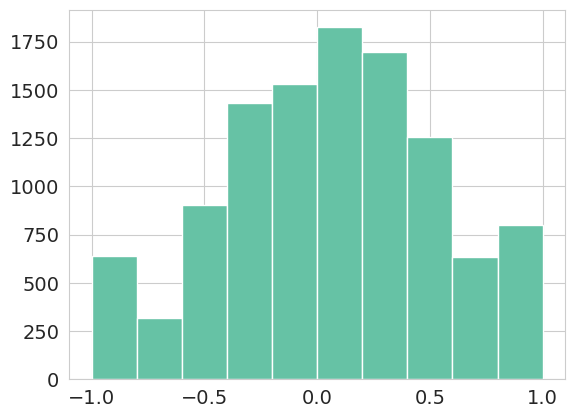

In [41]:
df_lda["alpha"].hist()

# Price prediction

/users/eleves-b/2020/thibaud.gloaguen/4A/crypto-nlp/modules/btc_price_data_processing.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dfh = btc_df.groupby(pd.Grouper(key="datetime", freq=freq))["open"].first().to_frame().copy()


(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Cumulative Realized Performance'}, xlabel='Date', ylabel='Cumulative Performance'>)

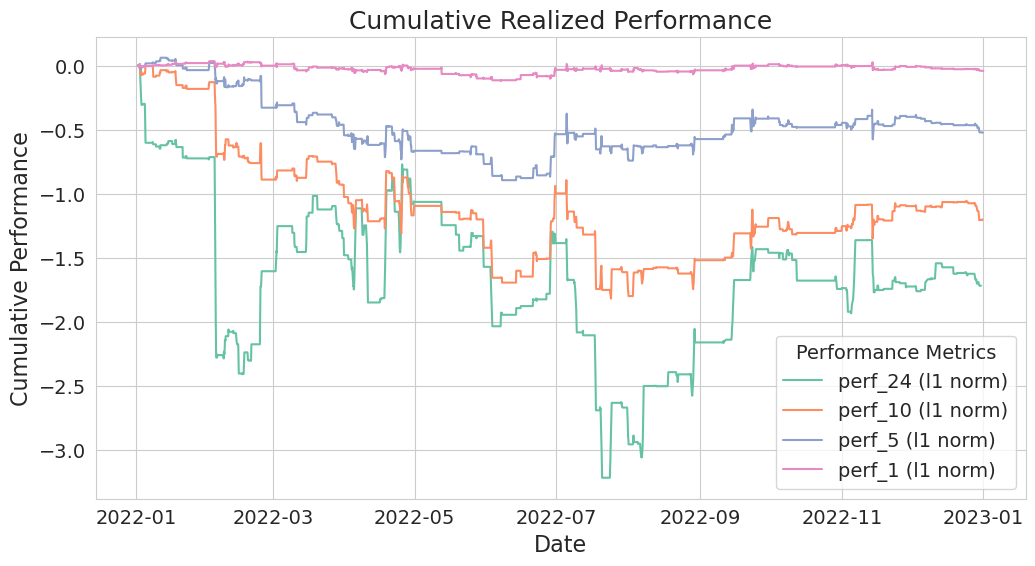

In [45]:
plot_df = df_lda.copy()

plot_df = add_performance_metrics(plot_df, [1,5,10,24])


perfs = [c for c in plot_df.columns if "perf" in c]
plot_realization(plot_df, "alpha", perfs, "l1", threshold=0.9)